- 사기거래탐지

# EDA

### 데이터 불러오기

In [1]:
!pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pgeocode #우편 변호 지원 
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc,precision_score, recall_score, matthews_corrcoef,log_loss
from haversine import haversine, haversine_vector, Unit # 지리적 거리 차이 계산
warnings.filterwarnings('ignore')
from sklearn.ensemble import StackingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [3]:
card_df = pd.read_csv('../data/ftd/cards_data.csv')
trans_df = pd.read_csv('../data/ftd/transactions_data.csv')
user_df = pd.read_csv('../data/ftd/users_data.csv')
mcc_df = pd.read_json('../data/ftd/mcc_codes.json', orient='index').rename({0:'category'}, axis=1)
fraud_df = pd.read_json('../data/ftd/train_fraud_labels.json')

### 데이터별 컬럼 의미

In [4]:
# card_df

- **id**: 카드 id 
- **client**: 고객 id
- **card_brand**: 카드사
- **card_type**: 카드 종류(신용/체크)
- **card_number**: 카드번호
- **expires**: 카드 만료기간
- **cvv**: 카드 인증코드
- **has_chip**: 카드 IC칩 보유 여부(IC칩 있을 시 카드 도용/복제에 상대적으로 안전)
- **num_cards_issued**: 문제 발생 횟수??
- **credit_limit**: 신용 한도
- **acct_open_date**: 계좌 개설일
- **year_pin_last_changed**: 카드 pin번호 최근 변경연도
- **card_on_dark_web**: 다크웹 사용?? => No만 존재 => 제거 가능

In [5]:
# trans_df

- **id**: 거래식별번호
- **date**: 거래일자
- **client_id**: 고객id
- **card_id**: 카드id
- **amount**: 거래금액 => 음수 데이터 존재
- **use_chip**: 카드 결제 방식
    - Swipe Transaction: 마그네틱 카드로 긁어서 결제
    - Chip Transaction: ic칩 카드로 결제
    - Online Transaction: 온라인 결제
- **merchant_id**: 매장id
- **merchant_city**: 매장 위치(시)
- **merchant_state**: 매장 위치(주)
- **zip**: 매장 우편번호
- **mcc**: 매장 분류코드
- **errors**: 거래 성공 여부(결제 오류 시 오류 원인이 적혀있음)

In [6]:
# user_df

- **id**: 고객id
- **current_age**: 현재 나이
- **retirement_age**: 퇴직 연령
- **birth_year**: 출생연도
- **gender**: 성별
- **address**: 주소
- **latitude**: 위도
- **longitude**: 경도
- **per_capita_income**: 1인당 소득 (전체 소득 / 인구 수)
- **yearly_income**: 연봉
- **total_debt**: 채무액
- **credit_score**: 신용점수
- **num_credit_cards**: 보유 중인 신용카드 수

In [7]:
mcc_df.reset_index()

,index,category
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees
...,...,...
104,7549,Towing Services
105,5941,Sporting Goods Stores
106,5722,Household Appliance Stores
107,3009,Fabricated Structural Metal Products


- mcc별 상점 종류

In [8]:
fraud_df.reset_index()

,index,target
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No
...,...,...
8914958,14064699,No
8914959,7676538,No
8914960,15131030,No
8914961,17244732,No


- 거래 id별 정상거래/사기거래 여부

### 데이터 살펴보기

In [9]:
user_df = user_df.rename(columns={'id':'client_id'}) #user_df의 id를 client_id로 변경
card_user_df = card_df.merge(user_df, on='client_id') #카드 정보와 고객 정보를 병함(카드 데이터를 기준으로)

card_user_df = card_user_df.drop(columns=['card_number','cvv']) #카드 번호, cvv(보안 번호, cvc 번호랑 비슷함) 삭제
card_user_df = card_user_df.rename(columns={'id':'card_id'}) #card_df의 id를 card_id로 변경

In [10]:
mcc_df = mcc_df.reset_index() #index 초기화
fraud_df = fraud_df.reset_index()

fraud_df = fraud_df.rename(columns={'index':'id','target':'fraud_label'}) #fraud_df의 index를 id로 변경,target를 fraud_label로 변경
mcc_df = mcc_df.rename(columns={'index':'mcc','category':'merchant_cat'}) #mcc_df의 index를 id로 변경,category를 merchant_cat로 변경

trans_df = trans_df.merge(fraud_df, on='id',how='left') #거래 정보와 사기 정보 결합
trans_df = trans_df.merge(mcc_df, on='mcc',how='left') #거래 정보와 판매점 정보 결합

#거래, 카드, 고객 정보 통합
trans_df = trans_df.merge(card_user_df, on=['card_id','client_id'],how='left')

#### trans_df

- date는 datetime으로 바꾸는게 좋아보임
- amount 음수인 경우 확인 필요

- errors의 결측치: 결제 성공 의미 => NaN대신 다른 값으로 변환 필요해 보임
- merchant_state => Italy 사기거래 백분율 65% => 단순 우연?
- zip => 별 의미 없는 데이터

#### 생각해볼만한 것

- card_brand와 사기거래 관련성
- card_type과 사기거래 관련성
- has_chip과 사기거래 관련성
- credit_limit과 사기거래 관련성

- date와 사기거래 관련성
- amount와 사기거래 관련성
- use_chip과 사기거래 관련성
- merchant_state와 사기거래 관련성
- category와 사기거래 관련성

- current_age와 사기거래 관련성
- gender과 사기거래 관련성
- latitude, longitude와 사기거래 관련성
- yearly_income와 사기거래 관련성
- credit_score와 사기거래 관련성
- num_credit_cards와 사기거래 관련성

### 중복값 확인

In [11]:
#mcc_df[mcc_df.duplicated(keep=False)]

- trans_df와 합치면 상관없음

# Feature Engineering

해결해야 하는 문제

- 제거를 고려하는 변수들: address, latitude, longitude
  
- 해 마다 갱신 될 가능성이 높은 변수들: total_debt, credit_score(FICO Score로 추정됨)

- merchant_state,city 의 처리

In [12]:
# mcc 범주화
food = ['Eating Places and Restaurants', 'Fast Food Restaurants', 'Drinking Places (Alcoholic Beverages)', 'Grocery Stores, Supermarkets', 
              'Miscellaneous Food Stores', 'Package Stores, Beer, Wine, Liquor', 'Wholesale Clubs', 'Discount Stores']

medical = ['Medical Services', 'Doctors, Physicians', 'Dentists and Orthodontists', 'Chiropractors', 'Podiatrists',
                    'Optometrists, Optical Goods and Eyeglasses', 'Hospitals', 'Drug Stores and Pharmacies']

transport = ['Service Stations', 'Automotive Service Shops', 'Automotive Body Repair Shops', 'Automotive Parts and Accessories Stores',
                       'Taxicabs and Limousines', 'Bus Lines', 'Passenger Railways', 'Railroad Passenger Transport', 'Railroad Freight',
                       'Motor Freight Carriers and Trucking', 'Airlines', 'Cruise Lines', 'Lodging - Hotels, Motels, Resorts',
                       'Local and Suburban Commuter Transportation']

service = ['Laundry Services', 'Car Washes', 'Towing Services', 'Cleaning and Maintenance Services', 'Tax Preparation Services',
                   'Accounting, Auditing, and Bookkeeping Services', 'Legal Services and Attorneys', 'Detective Agencies, Security Services', 'Money Transfer',
                   'Insurance Sales, Underwriting', 'Travel Agencies']

retail = ['Department Stores', 'Family Clothing Stores', "Women's Ready-To-Wear Stores", 'Shoe Stores', 'Sports Apparel, Riding Apparel Stores',
              'Sporting Goods Stores', 'Leather Goods', 'Precious Stones and Metals', 'Antique Shops', 'Music Stores - Musical Instruments',
              'Artist Supply Stores, Craft Shops', 'Book Stores', 'Books, Periodicals, Newspapers', 'Electronics Stores',
              'Computers, Computer Peripheral Equipment', 'Digital Goods - Media, Books, Apps', 'Digital Goods - Games', 'Cosmetic Stores',
              'Beauty and Barber Shops', 'Gift, Card, Novelty Stores', 'Miscellaneous Home Furnishing Stores', 
              'Furniture, Home Furnishings, and Equipment Stores', 'Upholstery and Drapery Stores', 'Lighting, Fixtures, Electrical Supplies',
              'Floor Covering Stores', 'Lawn and Garden Supply Stores', 'Gardening Supplies', 'Hardware Stores', 'Household Appliance Stores',
              'Florists Supplies, Nursery Stock and Flowers', 'Non-Precious Metal Services']

industry = ['Lumber and Building Materials', 'Brick, Stone, and Related Materials', 'Industrial Equipment and Supplies',
                    'Tools, Parts, Supplies Manufacturing', 'Heating, Plumbing, Air Conditioning Contractors', 'Fabricated Structural Metal Products',
                    'Steel Products Manufacturing', 'Steelworks', 'Ironwork', 'Welding Repair', 'Electroplating, Plating, Polishing Services',
                    'Heat Treating Metal Services', 'Bolt, Nut, Screw, Rivet Manufacturing', 'Coated and Laminated Products', 'Non-Ferrous Metal Foundries',
                    'Steel Drums and Barrels', 'Miscellaneous Metal Fabrication', 'Miscellaneous Metals', 'Miscellaneous Fabricated Metal Products',
                    'Miscellaneous Metalwork', 'Pottery and Ceramics', 'Semiconductors and Related Devices', 'Ship Chandlers',
                    'Utilities - Electric, Gas, Water, Sanitary', 'Telecommunication Services', 'Computer Network Services', 
                    'Cable, Satellite, and Other Pay Television Services', 'Postal Services - Government Only', 'Tolls and Bridge Fees', 
                    'Amusement Parks, Carnivals, Circuses', 'Motion Picture Theaters', 'Theatrical Producers', 'Recreational Sports, Clubs', 
                    'Athletic Fields, Commercial Sports', 'Betting (including Lottery Tickets, Casinos)', 'Miscellaneous Machinery and Parts Manufacturing']

In [13]:
trans_df.loc[trans_df['merchant_cat'].isin(food), 'merchant_cat'] = 'food'
trans_df.loc[trans_df['merchant_cat'].isin(medical), 'merchant_cat'] = 'medical'
trans_df.loc[trans_df['merchant_cat'].isin(transport), 'merchant_cat'] = 'transport'
trans_df.loc[trans_df['merchant_cat'].isin(service), 'merchant_cat'] = 'service'
trans_df.loc[trans_df['merchant_cat'].isin(retail), 'merchant_cat'] = 'retail'
trans_df.loc[trans_df['merchant_cat'].isin(industry), 'merchant_cat'] = 'industry'

In [14]:
trans_df['errors'] = trans_df['errors'].fillna(0) #정상 거래는 0값으로 처리

#merchant_city가 ONLINE 일 떄 merchant_state도 ONLINE으로 변경
trans_df.loc[trans_df['merchant_city'] == 'ONLINE', 'merchant_state'] = 'ONLINE'

#고객 ID, 카드 ID, 다크웹에서 카드?,거래 id, 상점 id, 상점 카테고리 식별 번호 삭제
trans_df = trans_df.drop(columns=['id','merchant_id','mcc','client_id','card_on_dark_web'])

In [15]:
trans_df['date'] = pd.to_datetime(trans_df['date']) #date의 데이터 구조를 datetime으로 변환

#금액에서 $표시를 제거해서 돈과 관련된 수치를 숫자로 변환
trans_df['amount'] = pd.to_numeric(trans_df['amount'].str.split('$', expand=True)[1]) #
trans_df['credit_limit'] = pd.to_numeric(trans_df['credit_limit'].str.split('$', expand=True)[1]) #
trans_df['per_capita_income'] = pd.to_numeric(trans_df['per_capita_income'].str.split('$', expand=True)[1])
trans_df['yearly_income'] = pd.to_numeric(trans_df['yearly_income'].str.split('$', expand=True)[1])
trans_df['total_debt'] = pd.to_numeric(trans_df['total_debt'].str.split('$', expand=True)[1])

In [16]:
#거래 날짜와 고객,카드 정보를 통해 시간과 관련된 새로운 피쳐 생성

trans_df['day'] = trans_df['date'].dt.day #거래 당시의 일 생성
trans_df['month'] = trans_df['date'].dt.month #거래 당시의 월 생성
trans_df['year'] = trans_df['date'].dt.year #거래 당시의 년 생성

trans_df['expire_month'] = pd.to_numeric(trans_df['expires'].str.split('/', expand=True)[0]) #카드 만료 날의 월 
trans_df['expire_year'] = pd.to_numeric(trans_df['expires'].str.split('/', expand=True)[1]) #카드 만료 날의 년

trans_df['acct_open_date_month'] = pd.to_numeric(trans_df['acct_open_date'].str.split('/', expand=True)[0]) #계좌 개설 날의 월 
trans_df['acct_open_date_year'] = pd.to_numeric(trans_df['acct_open_date'].str.split('/', expand=True)[1]) #계좌 개설 날의 년

trans_df['current_age'] = trans_df['year'] - trans_df['birth_year'] #현재 나이를 2019년이 아닌 거래 날짜를 기준으로 변경
trans_df['year_since_pin_changed'] = trans_df['year'] - trans_df['year_pin_last_changed'] #핀 번호 변경으로 부터 지난 해 기간
trans_df['year_since_pin_changed'] = trans_df['year_since_pin_changed'].clip(lower=0) #핀 번호 갱신 기간이 음수인 경우 0으로 변환
trans_df['years_to_retirement'] = trans_df['retirement_age'] - trans_df['current_age'] #은퇴까지 남은 년

trans_df['month_to_expires'] = (12*(trans_df['expire_year'] - trans_df['year']) 
                                + (trans_df['expire_month'] - trans_df['month'])) #카드 만료까지 남은 개월 수

trans_df['month_to_acct_open'] = (12*(trans_df['year'] - trans_df['acct_open_date_year']) 
                                + (trans_df['month'] - trans_df['acct_open_date_month'])) #계좌 개설 후 지난 개월 수


In [26]:
trans_df['hour'] = trans_df['date'].dt.hour #거래 당시의 시간 
trans_df['min'] = trans_df['date'].dt.minute #거래 당시의 분  
minutes_in_day = 24 * 60 #최대 분/ 각도

trans_df['total_min'] = 60*trans_df['hour'] + trans_df['min'] #거래 당시의 시간대(분 단위)

trans_df['time_sin'] = np.sin(2 * np.pi * trans_df['total_min'] / minutes_in_day) #sine 값으로 변환
trans_df['time_cos'] = np.cos(2 * np.pi * trans_df['total_min'] / minutes_in_day) #cosine 값으로 변환

trans_df['time_angle'] = np.arctan2(trans_df['time_sin'], trans_df['time_cos']) #sin, cos 값으로 24시를 기준으로 한 각도를 계산
#각도 값이 음수이면 2pi를 더해 양수로 변환
trans_df['time_angle'] = np.where(trans_df['time_angle'] < 0, trans_df['time_angle'] + 2 * np.pi, trans_df['time_angle']) 

#해당 고객의 최근 거래 15건의 시간대의 이동 평균 계산 (사용한 카드 기준)

#sin의 최근 15건의 이동평균
trans_df['time_15_ma_sin'] = trans_df.groupby('card_id')['time_sin'].rolling(window=15, min_periods=1).mean().reset_index(level=0, drop=True)
#cos의 최근 15건의 이동평균
trans_df['time_15_ma_cos'] = trans_df.groupby('card_id')['time_cos'].rolling(window=15, min_periods=1).mean().reset_index(level=0, drop=True)
#최근 15건의 각도의 이동평균
trans_df['15_ma_angle'] = np.arctan2(trans_df['time_15_ma_sin'], trans_df['time_15_ma_cos'])
#각도 값이 음수이면 2pi를 더해 양수로 변환
trans_df['15_ma_angle'] = np.where(trans_df['15_ma_angle'] < 0, trans_df['15_ma_angle'] + 2 * np.pi, trans_df['15_ma_angle'])

trans_df['angle_diff'] = np.abs(trans_df['15_ma_angle']-trans_df['time_angle'])#거래 시간의 각도와 이동 평균과 거래 시간의 각도 차이

trans_df['angle_15_ma'] = np.minimum(trans_df['angle_diff'], 2 * np.pi - trans_df['angle_diff']).round(2) #각도 최단 거리 

In [27]:
trans_df = trans_df.drop(columns=['birth_year','birth_month','date','year_pin_last_changed','retirement_age','expires','acct_open_date',
                                 'expire_month','expire_year','acct_open_date_month','acct_open_date_year',
                                  'total_min','time_sin','time_cos','time_15_ma_sin','time_15_ma_cos','15_ma_angle','angle_diff'
                                 ])

- 소비자 물가 지수(CPI)로 년마다 연봉 갱신

|연도|소비자 물가 지수|단위 환산|
|------|---|---|
|2010년|218.1|85.30|
|2011년|224.9|87.95|
|2012년|229.6|89.79|
|2013년|232.9|91.08|
|2014년|236.7|92.57|
|2015년|237.0|92.69|
|2016년|240.0|93.86|
|2017년|245.1|95.85|
|2018년|251.1|98.20|
|2019년|255.7|100|

출처: https://ko.tradingeconomics.com/united-states

In [28]:
#소비자 물기 지수(CPI)로 연봉을 평준화 
CPI = {2019:1, 2018:0.982 ,2017:0.9585,2016:0.9386, 2015:0.9269, 2014:0.9257, 2013:0.9108, 2012:0.8979, 2011:0.8795, 2010:0.853}

trans_df['CPI'] = trans_df['year'].map(CPI)
trans_df['per_capita_income'] = trans_df['per_capita_income']*trans_df['CPI'] #지역 연봉 * CPI 지수 가중치
trans_df['yearly_income'] = trans_df['yearly_income']*trans_df['CPI'] #연봉 * CPI 지수 가중치
trans_df = trans_df.drop(columns=['CPI'])

In [29]:
#지리 정보를 이용한 feature engineering

manual_coords = {
    '30399': (33.7490, -84.3880), '94101': (37.7834, -122.4194),
    '98205': (47.9790, -122.2021), '10072': (40.7766, -73.9525),
    '19640': (40.3356, -75.9269), '45418': (39.7589, -84.1916),
    '21748': (39.6418, -77.7200), '10558': (40.9126, -73.8385),
    '92164': (32.7157, -117.1611), '14645': (43.1566, -77.6088),
    '33121': (25.7617, -80.1918), '17767': (41.2951, -77.1641),
    '16532': (42.1292, -80.0851), '29573': (33.6891, -78.8867),
    '19388': (39.9607, -75.6055), '41338': (37.5551, -83.3882),
    '21681': (39.2157, -76.0694), '19483': (40.0970, -75.3888),
    '40446': (37.4298, -83.9785), '92412': (34.1083, -117.2898),
    '11594': (40.7559, -73.5876), '25965': (37.6729, -80.8906)
} #우편번호 라이브러리에 등록되지 않은 위치 정보

#상점 우편 번호로 상점의 위도 경도 지리 정보 추출
geo_locator = pgeocode.Nominatim('us') #미국 우편 번호 객체 생성

trans_df['zip'].fillna(0, inplace=True) #결측치 채우기
trans_df['zip_str'] = trans_df['zip'].astype(int).astype(str).str.zfill(5) #우편 번호를 문자열로 저장
geo_info = geo_locator.query_postal_code(trans_df['zip_str'].tolist()) #우편 번호를 위도, 경도로 변환

trans_df['market_latitude'] = geo_info['latitude'] #거래 데이터에 상점의 위도, 경도 정보 저장
trans_df['market_longitude'] = geo_info['longitude']

#라이브러리에 등록되지 않는 위도, 경도 정보를 딕션너리로 변환
lat_map = {zip_code: coords[0] for zip_code, coords in manual_coords.items()} #위도 정보 변환
lon_map = {zip_code: coords[1] for zip_code, coords in manual_coords.items()} #경도 정보 변환

#위도-경도 딕션너리를 매핑을 통해 거래 데이터에 저장
trans_df['market_latitude'] = trans_df['market_latitude'].fillna(trans_df['zip_str'].map(lat_map)) #결측치에 위도, 경도 정보 저장
trans_df['market_longitude'] = trans_df['market_longitude'].fillna(trans_df['zip_str'].map(lon_map))

#상점과 고객 주소 간의 거리 계산
client_coords = list(zip(trans_df['latitude'], trans_df['longitude'])) #고객 주소 좌표
market_coords = list(zip(trans_df['market_latitude'], trans_df['market_longitude'])) #상점 주소 좌표
trans_df['distance_km'] = haversine_vector(client_coords, market_coords, unit=Unit.KILOMETERS) #고객과 상점 거리를 km 단위로 계산

#해당 고객의 최근 거래 15건의 상점-주소 거리의 이동 평균 계산
trans_df['distance_15_ma'] = trans_df.groupby('card_id')['distance_km'].rolling(window=15, min_periods=1).mean().reset_index(level=0, drop=True)

# 소수점 둘째 자리까지 반올림
trans_df['distance_15_ma'] = np.abs(trans_df['distance_km']- trans_df['distance_15_ma']).round(2) #이동 평균과 거리 차이로 계산
trans_df['distance_km'] = trans_df['distance_km'].round(2)

us_state_codes = {
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
    'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
    'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
    'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'} #미국 50개 주 +D.C(워싱턴)

condition = trans_df['merchant_state'].isin(us_state_codes) # 상점 위치가 미국 내인지 판단
trans_df['national'] = np.where(condition, 'domestic', 'overseas') #미국 내이면 'domestic', 해외면 'overseas' 값을 가짐

#상점 위치가 해외이면 merchant_state 값을 overseas로 변환
condition2 = (trans_df['national'] == 'overseas') & (trans_df['merchant_city'] != 'ONLINE')
trans_df.loc[condition2, 'merchant_state'] = 'overseas'

In [30]:
#거래 금액 관련 feature-engineering

condition = trans_df['amount'] < 0 #거래 금액이 음수인지 판단(환불 거래)
trans_df['refund'] = np.where(condition,1,0)
trans_df['amount'] = np.abs(trans_df['amount']) #거래 금액을 양수로 바꿈

window_size = 200 #최근 200개 데이터 선별

def count_current_customer(window):
    current_customer = window.iloc[-1]
    return (window == current_customer).sum()

#최근 200개 거래 데이터 중 현재 고객의 거래 건수 총합을 계산
trans_df['recent_trans'] = trans_df['card_id'].rolling(window=window_size, min_periods=1).apply(count_current_customer, raw=False)



In [31]:
#고객 정보와 환불 정보 통합 
trans_df['combo_id'] = trans_df['card_id'].astype(str) + trans_df['refund'].astype(str)*3
trans_df['combo_id'] = trans_df['combo_id'].astype(int)


def refund_count_current_customer(window):
    current_customer = str(int(window.iloc[-1]))
    target_id = int(current_customer[:4] + '111')
    
    return (window == target_id).sum()
   
#최근 200개 거래 데이터 중 현재 고객의 환불 거래 건수 총합을 계산
trans_df['recent_refund_trans'] = trans_df['combo_id'].rolling(window=window_size, min_periods=1).apply(refund_count_current_customer, raw=False)

#해당 고객의 최근 거래 15건의 거래 금액의 이동 평균 계산
trans_df['amount_15_ma'] = trans_df.groupby('card_id')['amount'].rolling(window=15, min_periods=1).mean().reset_index(level=0, drop=True)

#거래 금액과 최근 15건의 거래 금액 평균의 차이 
trans_df['amount_15_ma'] = np.abs(trans_df['amount']- trans_df['amount_15_ma']).round(2) 

In [32]:
#필요 없는 정보 제거
trans_df = trans_df.drop(columns=['address','latitude','longitude','zip','zip_str','combo_id',
                                  'market_latitude','market_longitude','card_id','merchant_city','national'])

In [33]:
train_trans_df = trans_df[trans_df['fraud_label'].notnull()] # 사기 정보가 있는 데이터 900만개
test_trans_df = trans_df[trans_df['fraud_label'].isnull()] # 사기 정보가 없는 데이터  400만개

#사기 거래 정보 값을 Yes, NO에서 1,0으로 변경
YN_dict = {"Yes": 1, "No" : 0}
train_trans_df['fraud_label'] = train_trans_df['fraud_label'].map(YN_dict)

In [34]:
#feature
train_trans_df.columns

Index(['amount', 'use_chip', 'merchant_state', 'errors', 'fraud_label',
       'merchant_cat', 'card_brand', 'card_type', 'has_chip',
       'num_cards_issued', 'credit_limit', 'current_age', 'gender',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'day', 'month', 'year', 'year_since_pin_changed',
       'years_to_retirement', 'month_to_expires', 'month_to_acct_open', 'hour',
       'min', 'time_angle', 'angle_15_ma', 'distance_km', 'distance_15_ma',
       'refund', 'recent_trans', 'recent_refund_trans', 'amount_15_ma'],
      dtype='object')

In [2]:
train_trans_df.to_pickle("train_features.pkl")
test_trans_df.to_pickle("test_features.pkl")

NameError: name 'train_trans_df' is not defined

In [3]:
train_trans_df = pd.read_pickle("train_features.pkl")
test_trans_df = pd.read_pickle("test_features.pkl")


<span style="font-size: 22px; color: black">**추가된 변수**</span>

- **day**: 거래된 일
- **month**: 거래된 월
- **year**: 거래된 년
- **hour**: 거래된 시간
- **min**: 거래된 분
- **year_since_pin_changed**: 핀 번호 변경으로 부터 지난 년
- **years_to_retirement**: 은퇴까지 남은 년
- **month_to_expires**: 카드 만료까지 남은 달
- **month_to_acct_open**: 계좌 개설로 부터 지난 달
- **distance_km**: 상점과 고객 주소의 거리 차이(km)
- **distance_15_ma**" 최근 15번 거래의 상점-고객 거리의 이동 평균과 현재 거래에서 거리의 차이(카드 기준) 
- **time_15_ma**" 최근 15번 거래의 거래 시간의 이동 평균과 현재 거래에서 시간대 차이 (카드 기준)
- **refund**: 환불 여부
- **recent_trans**:최근 거래 횟수
- **recent_refund_trans**:최근 환불 횟수
- **amount_15_ma**: 최근 15번 거래의 거래 금액 평균과 거래 금액 차이


<span style="font-size: 22px; color: black">**변경된 변수**</span>

- **fraud_label**: NO, Yes를 0,1로 변경
- **current_age**: 현재 나이를 2019년 기준에서 거래 당시 시간으로 변경
- **per_capita_income**: 수입 기준을 2019년에서 CPA를 적용해서 년마다 갱신
- **yearly_income**: 연봉 기준을 2019년에서 CPA를 적용해서 년마다 갱신
- **merchant_state**: 해외는 overseas, 미국 내는 주, 온라인 거래는 ONLINE 으로 변경


In [4]:
train_trans_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8914963 entries, 0 to 13305912
Data columns (total 35 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   amount                  float64
 1   use_chip                object 
 2   merchant_state          object 
 3   errors                  object 
 4   fraud_label             int64  
 5   merchant_cat            object 
 6   card_brand              object 
 7   card_type               object 
 8   has_chip                object 
 9   num_cards_issued        int64  
 10  credit_limit            int64  
 11  current_age             int64  
 12  gender                  object 
 13  per_capita_income       float64
 14  yearly_income           float64
 15  total_debt              int64  
 16  credit_score            int64  
 17  num_credit_cards        int64  
 18  day                     int32  
 19  month                   int32  
 20  year                    int32  
 21  year_since_pin_changed  int64  
 22

In [5]:
train_trans_df = pd.get_dummies(train_trans_df,columns = ['use_chip','merchant_state','errors','merchant_cat',
                                         'card_brand','card_type','has_chip','gender'],drop_first=True)

In [50]:
'''
# # 결측치 개수 확인
missing_counts = X_val.isnull().sum()

# # 결측치가 있는 칼럼만 추출
missing_cols = missing_counts[missing_counts > 0]

if missing_cols.empty:
    print(" 결측치가 없습니다! 모든 칼럼이 안전합니다.")
else:
    print(" 결측치가 있는 칼럼 발견:")
    print(missing_cols)
    print("\n총 결측치 개수:", missing_counts.sum())
'''

 결측치가 있는 칼럼 발견:
distance_km       221643
distance_15_ma    221643
dtype: int64

총 결측치 개수: 443286


In [6]:
# distance_km, distance_15_ma 결측치를 평균값으로 대체
train_trans_df["distance_km"].fillna(0, inplace=True)
train_trans_df["distance_15_ma"].fillna(0, inplace=True)

# 확인
print(train_trans_df[["distance_km", "distance_15_ma"]].isnull().sum())


distance_km       0
distance_15_ma    0
dtype: int64


In [17]:
#모델 피클로 저장 
'''
import pickle

with open('rf_model.pkl','wb') as f:
    pickle.dump(rf_model,f)
with open('log_model.pkl','wb') as f:
    pickle.dump(log_model,f)
with open('lgb_model.pkl','wb') as f:
    pickle.dump(lgb_model,f)
with open('xgb_model.pkl','wb') as f:
    pickle.dump(xgb_model,f)
'''

In [17]:
#저장된 모델 불러오기
import pickle
'''
with open('rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)   
with open('log_model.pkl', 'rb') as f:
    log_model = pickle.load(f) 
with open('lgb_model.pkl', 'rb') as f:
    lgb_model = pickle.load(f) 
with open('xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f) 
'''    

In [ ]:
train_trans_df.info()

- target은 fraud_label
- fraud_label 값이 0: 정상 거래 1: 사기 거래

- 학습할 데이터: train_trans_df (X,y 분리 안되어 있음)

# 레이블인코딩

# 레이블인코딩

In [ ]:
# label_encoders = {}

# categorical_cols = train_trans_df.select_dtypes(include=["object"]).columns

# for col in categorical_cols:
#     le = LabelEncoder()
#     train_trans_df[col] = le.fit_transform(train_trans_df[col].astype(str))
#     test_trans_df[col] = le.transform(test_trans_df[col].astype(str)) 
#     label_encoders[col] = le


###  데이터셋 준비

In [14]:
X = train_trans_df.drop("fraud_label", axis=1)
y = train_trans_df["fraud_label"] 

### 데이터 스플릿 및 각종지표 함수화

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def evaluate_model(model, X_val, y_val, model_name="Model"):
    # 예측값과 확률
    preds = model.predict(X_val)
    probas = model.predict_proba(X_val)[:, 1]

    # 주요 지표
    #사기vs정상을 구분하는 능력 0.5=랜덤추측,1.0=완벽한 구분
    roc_auc = roc_auc_score(y_val, probas)
    
    #precision vs recall 의 균형 0 ~ 1.0 ,0.6이상
    f1 = f1_score(y_val, preds)
    
    #정밀도(precision) 높을수록 좋음 0.8이상 양호 0.9 이상 최상
    #사기라고 예측한 거래중 실제 사기 비율 - 고객불편
    #recall 높을수록 좋음 0.7이상 양호 0.9이상 최상
    #실제 사기거래중에서 모델이 잡아낸 비율 - 금전손실위험
    # 실제 사기 거래 중에서 모델이 얼마나 잘 잡아내는지를 보기 위해
    # 다양한 threshold(0~1)를 기준으로 Precision과 Recall 값을 계산
    precision, recall, _ = precision_recall_curve(y_val, probas)

    # Precision-Recall 곡선의 면적 (0~1.0 사이 값)
    # 불균형 데이터에서 모델 성능을 평가할 때 특히 중요
    # 0.7 이상이면 좋은 편, 값이 클수록 사기 거래 탐지 능력이 우수
    pr_auc = auc(recall, precision)

    # 특정 threshold(기본적으로 0.5) 기준에서의 Precision 값
    # '사기라고 예측한 거래 중에서 실제 사기 비율'을 의미
    # Precision이 낮으면 정상 거래를 잘못 사기로 예측(FP)이 많다는 뜻
    prec = precision_score(y_val, preds)
    
    rec = recall_score(y_val, preds)

    #-1~1 사이값
    # 0.5이상 안정적 0.7 이상이면 우수
    mcc = matthews_corrcoef(y_val, preds)

    #0이상의값 
    #작을수록 좋음 0.3 이하 우수
    loss = log_loss(y_val, probas)

    #TN (8500): 정상 → 정상 맞춤

    # FP (300): 정상인데 사기라고 잘못 탐지
    
    # FN (200): 사기인데 정상으로 놓침 ⚠️ (가장 위험)
    
    # TP (1000): 사기 → 사기 맞춤
    cm = confusion_matrix(y_val, preds)

    # 출력
    print(f"\n {model_name} 결과")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"LogLoss: {loss:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_val, preds))

    return {
        "roc_auc": roc_auc,
        "f1": f1,
        "pr_auc": pr_auc,
        "precision": prec,
        "recall": rec,
        "mcc": mcc,
        "log_loss": loss,
        "confusion_matrix": cm
    }



In [10]:
# # 테스트 데이터 30%
train_sample = train_trans_df.sample(frac=0.3, random_state=42)
X = train_sample.drop("fraud_label", axis=1)
y = train_sample["fraud_label"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [38]:
# X_train.columns = [f"f{i}" for i in range(X_train.shape[1])]
# X_val.columns = X_train.columns
# y_train = y_train.squeeze()
# y_val   = y_val.squeeze()
# X_train = X_train.astype("float32")
# X_val = X_val.astype("float32")


MemoryError: Unable to allocate 1.38 GiB for an array with shape (52, 7131970) and data type float32

### RM모델

In [15]:
rf_model = RandomForestClassifier(
    n_estimators=300,        # 트리 개수 (클수록 안정적, 속도 느려짐)0
    max_depth=None,          # 트리 최대 깊이 (None이면 리프까지 분할)0
    max_features="sqrt",     # 각 분할에서 고려할 최대 피처 수 ("sqrt", "log2", int, float)0
    random_state=42,         # 랜덤 시드0
    class_weight="balanced",  # 클래스 불균형 보정0
    n_jobs=-1,               # 병렬 처리할 CPU 코어 수
)

rf_model.fit(X_train, y_train)
res_rf = evaluate_model(rf_model, X_val, y_val, "RandomForest")



 RandomForest 결과
ROC-AUC: 0.9836
F1: 0.3973
PR-AUC: 0.7040
Precision: 0.9584
Recall: 0.2506
MCC: 0.4897
LogLoss: 0.0046
Confusion Matrix:
[[1780298      29]
 [   1998     668]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.96      0.25      0.40      2666

    accuracy                           1.00   1782993
   macro avg       0.98      0.63      0.70   1782993
weighted avg       1.00      1.00      1.00   1782993



### LOG모델

In [9]:
log_model = LogisticRegression(
    C=1.0,                   # 규제 강도 (작을수록 규제 강함, 과적합 방지)
    max_iter=1000,           # 반복 횟수 (수렴 안 되면 늘리기)
    n_jobs=-1,               # 병렬 처리 (solver가 지원할 경우)
    random_state=42,         # 랜덤 시드
    class_weight="balanced"  # 클래스 불균형 보정
)

log_model.fit(X_train, y_train)
res_log = evaluate_model(log_model, X_val, y_val, "LogisticRegression")



 LogisticRegression 결과
ROC-AUC: 0.7819
F1: 0.0100
PR-AUC: 0.0089
Precision: 0.0051
Recall: 0.5941
MCC: 0.0425
LogLoss: 0.5947
Confusion Matrix:
[[1468250  312077]
 [   1082    1584]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1780327
           1       0.01      0.59      0.01      2666

    accuracy                           0.82   1782993
   macro avg       0.50      0.71      0.46   1782993
weighted avg       1.00      0.82      0.90   1782993



### LGB모델

In [10]:
lgb_model = lgb.LGBMClassifier(device='gpu',
    n_estimators=500,
    learning_rate=0.05,
    class_weight = "balanced", #가중치추가
    subsample=0.8,
    colsample_bytree=0.8,
    min_gain_to_split=0.05,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

lgb_model.fit(
    X_train.to_numpy(), y_train.to_numpy(),
    eval_set=[(X_val.to_numpy(), y_val.to_numpy())],
    categorical_feature=None
)
res_lgb = evaluate_model(lgb_model, X_val, y_val, "LightGBM")


 LightGBM 결과
ROC-AUC: 0.9957
F1: 0.1225
PR-AUC: 0.5694
Precision: 0.0655
Recall: 0.9467
MCC: 0.2462
LogLoss: 0.0569
Confusion Matrix:
[[1744308   36019]
 [    142    2524]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1780327
           1       0.07      0.95      0.12      2666

    accuracy                           0.98   1782993
   macro avg       0.53      0.96      0.56   1782993
weighted avg       1.00      0.98      0.99   1782993



## lgb 모델 결과해석
    - roc_auc
    - f1 양성거래는 잘 찾지만 오탐이 너무많음
    - precision 예측한것 중에 실제 사기일확률이 11%
    - recall 매우높음 사기의 약 94% 찾음

    요약 및 정리 사기거래는 잘 잡아내지만 오탐이 너무많아 실제모델로 사용하기엔 경고가 너무많아 무용지물 
    


### XGBBOOST모델

In [11]:
xgb_model = XGBClassifier(tree_method = "hist", device = "cuda",
    n_estimators=500,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)
res_xgb = evaluate_model(xgb_model, X_val, y_val, "XGBoost")



 XGBoost 결과
ROC-AUC: 0.9954
F1: 0.1320
PR-AUC: 0.5774
Precision: 0.0710
Recall: 0.9452
MCC: 0.2563
LogLoss: 0.0549
Confusion Matrix:
[[1747335   32992]
 [    146    2520]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1780327
           1       0.07      0.95      0.13      2666

    accuracy                           0.98   1782993
   macro avg       0.54      0.96      0.56   1782993
weighted avg       1.00      0.98      0.99   1782993



## xgb 모델 결과해석
    - roc_auc
    - f1 양성거래는 잘 찾지만 오탐이 너무많음
    - precision 예측한것에 약 7%만 사기 오탐이 많음 
    - recall 매우높음 사기의 약 94% 찾음 사기값을 잘잡아냄

    요약 및 정리 사기거래는 잘 잡아내지만 오탐이 너무많아 실제모델로 사용하기엔 경고가 너무많아 무용지물 
    


### CATBOOST모델

In [58]:
# neg, pos = np.bincount(y_train)
# scale_pos_weight = neg / pos

# cat_model = CatBoostClassifier(task_type='GPU',
#     iterations=500,
#     learning_rate=0.05,
#     depth=6,
#     class_weights=[1, scale_pos_weight], #가중치추가
#     random_seed=42,
#     verbose=100,
#     task_type="CPU"  
# )

# cat_model.fit(X_train, y_train)
# res_cat = evaluate_model(cat_model, X_val, y_val, "CatBoost")

## cat 모델 결과해석
    - roc_auc
    - precision 예측한것에 약 4.5%만 사기 오탐이 많음 
    - recall 매우높음 사기의 약 95% 찾음 사기값을 잘잡아냄



### 각종모델 성능비교

In [18]:
res_xgb = evaluate_model(xgb_model, X_val, y_val, "XGBoost")
res_lgb = evaluate_model(lgb_model, X_val, y_val, "LightGBM")
res_log = evaluate_model(log_model, X_val, y_val, "LogisticRegression")
res_rf = evaluate_model(rf_model, X_val, y_val, "RandomForest")


results = pd.DataFrame([res_log,res_rf,res_lgb,res_xgb], 
                       index=["Logistic","RandomFrest","LightGBM", "XGBoost"])
print("\n 최종 성능 비교")
print(results)


 XGBoost 결과
ROC-AUC: 0.9954
F1: 0.1320
PR-AUC: 0.5774
Precision: 0.0710
Recall: 0.9452
MCC: 0.2563
LogLoss: 0.0549
Confusion Matrix:
[[1747335   32992]
 [    146    2520]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1780327
           1       0.07      0.95      0.13      2666

    accuracy                           0.98   1782993
   macro avg       0.54      0.96      0.56   1782993
weighted avg       1.00      0.98      0.99   1782993


 LightGBM 결과
ROC-AUC: 0.9957
F1: 0.1225
PR-AUC: 0.5694
Precision: 0.0655
Recall: 0.9467
MCC: 0.2462
LogLoss: 0.0569
Confusion Matrix:
[[1744308   36019]
 [    142    2524]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1780327
           1       0.07      0.95      0.12      2666

    accuracy                           0.98   1782993
   macro avg       0.53      0.96      0.56   1782993
weight

| 지표            | 실무 최소 기준    | 현재 결과      | 코멘트                 |
| ------------- | ----------- | ---------- | ------------------- |
| **ROC-AUC**   | ≥ 0.80      | \~0.99     | 매우 우수, 문제 없음        |
| **PR-AUC**    | ≥ 0.30–0.40 | 0.52\~0.71 | LGBM은 특히 우수         |
| **Precision** | ≥ 0.10–0.20 | 0.04\~0.11 | LGBM만 최소 충족, 나머지 부족 |
| **Recall**    | ≥ 0.90      | 0.94\~0.96 | 충분히 우수              |
| **F1-score**  | ≥ 0.20      | 0.09\~0.20 | LGBM만 간신히 기준선       |
| **MCC**       | ≥ 0.30      | 0.20\~0.32 | LGBM만 간신히 기준선       |


## 성능비교 해석 
결론 LGBM을 메인으로 나머지를 보조지표로 사용해야함

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample" 
)

param_dist_rf = {
    "n_estimators": [200, 500, 1000],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

rf_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist_rf,
    n_iter=5,                 
    scoring="f1",              
    cv=3,                    
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

print("Best Params (RandomForest):", rf_search.best_params_)
print("Best Score (RandomForest):", rf_search.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [11]:
import re
#에러 발생시 실행 시킬 것
#데이터 셋 이름이 바뀜 lgbm 모델에서 중요!!!!!!!!!
'''
#열 이름에 특수 문자 제거
X_train.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in X_train.columns]

X_val.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in X_val.columns]
'''

In [12]:
from sklearn.model_selection import RandomizedSearchCV

lgb_model = lgb.LGBMClassifier(device='gpu',
    random_state=42,
     n_jobs=-1,                           
    class_weight="balanced"
)

param_dist_lgb = {
    "n_estimators": [200, 500, 1000],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [15, 31, 63],            # 트리 복잡도 제어
    "max_depth": [-1, 5, 10, 20],          # 트리 깊이
    "min_child_samples": [10, 20, 50, 100], # 최소 데이터 수
    "scale_pos_weight": [1, 10, 50, 100]   # 클래스 불균형 보정
}

# 랜덤 탐색
lgb_search = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_dist_lgb,
    n_iter=5,                 
    scoring="f1",             
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1
)

lgb_search.fit(X_train, y_train)

print("Best Params (LightGBM):", lgb_search.best_params_)
print("Best Score (LightGBM):", lgb_search.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Number of positive: 7110, number of negative: 4747536
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3733
[LightGBM] [Info] Number of data points in the train set: 4754646, number of used features: 101
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (145.10 MB) transferred to GPU in 0.075721 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[CV] END learning_rate=0.05, max_depth=20, min_child_samples=100, n_estimators=200, num_leaves=63, scale_pos_weight=50; total time=   6.1s
[LightGBM] [Info] Number of positive: 7111, number of negative:

In [24]:
#XGB 튜닝

base_xgb_model = XGBClassifier(tree_method = "hist", device = "cuda",
    random_state=42,
     n_jobs=-1, use_label_encoder=False,                          
    eval_metric="logloss"
)

param_dist_xgb = {
    "n_estimators": [200, 500, 1000],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [-1, 5, 10, 20],          # 트리 깊이
    "min_child_weight": [1, 5, 10],         # 최소 데이터 수
    "colsample_bytree": [0.7, 0.9, 1.0],
    "gamma": [0, 0.1, 0.5],               # 규제 강도
    "scale_pos_weight": [1, 10, 50, 100]   # 클래스 불균형 보정
}

# 랜덤 탐색
xgb_search = RandomizedSearchCV(
    base_xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=5,                 
    scoring="f1",             
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1
)

xgb_search.fit(X_train, y_train)

print("Best Params (XGBoost):", xgb_search.best_params_)
print("Best Score (XGBoost):", xgb_search.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=-1, min_child_weight=1, n_estimators=500, scale_pos_weight=50; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=-1, min_child_weight=1, n_estimators=500, scale_pos_weight=50; total time=   3.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=-1, min_child_weight=1, n_estimators=500, scale_pos_weight=50; total time=   3.5s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, scale_pos_weight=100; total time=  11.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, scale_pos_weight=100; total time=  11.3s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, scale_pos_weight=100; total time=  11.1s
[CV] END colsamp

### LGBM 튜닝 결과

In [20]:
lgb_model = lgb.LGBMClassifier(device='gpu',
    n_estimators=500,
    learning_rate=0.05,
    class_weight = "balanced", #가중치추가
    subsample=0.8,
    colsample_bytree=0.8,
    min_gain_to_split=0.05,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

lgb_model.fit(
    X_train.to_numpy(), y_train.to_numpy(),
    eval_set=[(X_val.to_numpy(), y_val.to_numpy())],
    categorical_feature=None
)
res_lgb = evaluate_model(lgb_model, X_val, y_val, "LightGBM")

lgb_model2 = lgb.LGBMClassifier(device='gpu',
    class_weight="balanced",                            
    n_estimators=1000,
    learning_rate=0.05,
    scale_pos_weight = 1, #가중치추가
    num_leaves = 63,
    max_depth = 5,
    min_child_samples = 100,                            
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

lgb_model2.fit(
    X_train.to_numpy(), y_train.to_numpy(),
    eval_set=[(X_val.to_numpy(), y_val.to_numpy())],
    categorical_feature=None
)
res_lgb2 = evaluate_model(lgb_model2, X_val, y_val, "LightGBM")

results = pd.DataFrame([res_lgb,res_lgb2], 
                       index=["튜닝 전","튜닝 후"])
print("\n 최종 성능 비교")
print(results)


 LightGBM 결과
ROC-AUC: 0.9957
F1: 0.1225
PR-AUC: 0.5694
Precision: 0.0655
Recall: 0.9467
MCC: 0.2462
LogLoss: 0.0569
Confusion Matrix:
[[1744308   36019]
 [    142    2524]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1780327
           1       0.07      0.95      0.12      2666

    accuracy                           0.98   1782993
   macro avg       0.53      0.96      0.56   1782993
weighted avg       1.00      0.98      0.99   1782993


 LightGBM 결과
ROC-AUC: 0.9955
F1: 0.1346
PR-AUC: 0.5840
Precision: 0.0725
Recall: 0.9445
MCC: 0.2590
LogLoss: 0.0521
Confusion Matrix:
[[1748105   32222]
 [    148    2518]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1780327
           1       0.07      0.94      0.13      2666

    accuracy                           0.98   1782993
   macro avg       0.54      0.96      0.56   1782993
weigh

### XGB 튜닝 결과

In [25]:
xgb_model2 = XGBClassifier(tree_method = "hist", device = "cuda",
    n_estimators=1000,
    learning_rate=0.1,
    colsample_bytree=0.7,
    scale_pos_weight=50,
    min_child_weight = 10,
    max_depth = 20, 
    gamma = 0.5,                       
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model2.fit(X_train, y_train)
res_xgb2 = evaluate_model(xgb_model2, X_val, y_val, "XGBoost")

results = pd.DataFrame([res_xgb,res_lgb2], 
                       index=["튜닝 전","튜닝 후"])
print("\n 최종 성능 비교")
print(results)


 XGBoost 결과
ROC-AUC: 0.9974
F1: 0.7495
PR-AUC: 0.8007
Precision: 0.8280
Recall: 0.6845
MCC: 0.7526
LogLoss: 0.0024
Confusion Matrix:
[[1779948     379]
 [    841    1825]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.83      0.68      0.75      2666

    accuracy                           1.00   1782993
   macro avg       0.91      0.84      0.87   1782993
weighted avg       1.00      1.00      1.00   1782993


 최종 성능 비교
       roc_auc        f1    pr_auc  precision    recall       mcc  log_loss  \
튜닝 전  0.995431  0.132013  0.577433   0.070962  0.945236  0.256288  0.054912   
튜닝 후  0.995545  0.134631  0.584027   0.072481  0.944486  0.258974  0.052148   

                     confusion_matrix  
튜닝 전  [[1747335, 32992], [146, 2520]]  
튜닝 후  [[1748105, 32222], [148, 2518]]  


In [26]:
lgb_model = lgb_model2 #lgbm튜닝된 모델로 교체
proba_lgb = lgb_model.predict_proba(X_val)[:, 1]

xgb_model = xgb_model2 #xgb튜닝된 모델로 교체
proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

### precision-recall 곡선 시각화

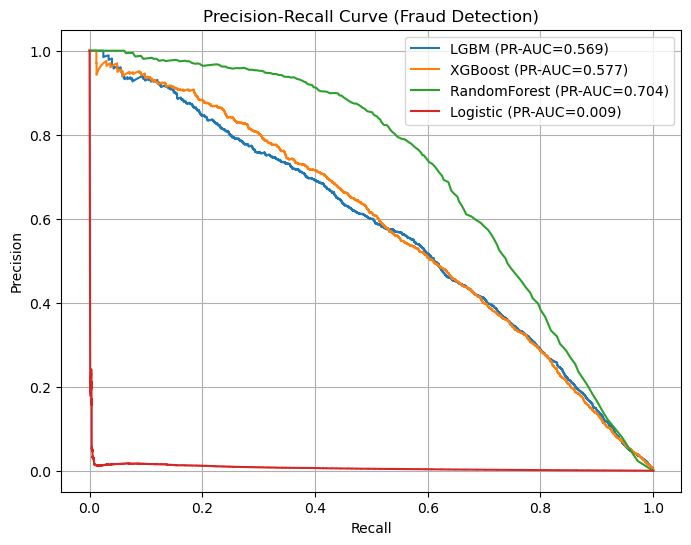

In [19]:
# 네 모델 예측 확률
proba_lgb = lgb_model.predict_proba(X_val)[:, 1]
proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
proba_rf  = rf_model.predict_proba(X_val)[:, 1]
proba_log = log_model.predict_proba(X_val)[:, 1]

# Precision-Recall 값 계산
precision_lgb, recall_lgb, _ = precision_recall_curve(y_val, proba_lgb)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_val, proba_xgb)
precision_rf,  recall_rf,  _ = precision_recall_curve(y_val, proba_rf)
precision_log, recall_log, _ = precision_recall_curve(y_val, proba_log)

# PR-AUC 계산
pr_auc_lgb = auc(recall_lgb, precision_lgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)
pr_auc_rf  = auc(recall_rf, precision_rf)
pr_auc_log = auc(recall_log, precision_log)

# 그래프 출력
plt.figure(figsize=(8,6))
plt.plot(recall_lgb, precision_lgb, label=f"LGBM (PR-AUC={pr_auc_lgb:.3f})")
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost (PR-AUC={pr_auc_xgb:.3f})")
plt.plot(recall_rf,  precision_rf,  label=f"RandomForest (PR-AUC={pr_auc_rf:.3f})")
plt.plot(recall_log, precision_log, label=f"Logistic (PR-AUC={pr_auc_log:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Fraud Detection)")
plt.legend()
plt.grid()
plt.show()


### 교차검증

In [ ]:

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
X = X.copy()
X.columns = [f"f{i}" for i in range(X.shape[1])]

def evaluate_model_cv(model, X, y, cv):
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1)
    pr_scores = cross_val_score(model, X, y, cv=cv, scoring="average_precision", n_jobs=-1)
    return f1_scores, pr_scores

models = {
    "LightGBM": lgb_model,
    "XGBoost": xgb_model,
    "RandomForest": rf_model,
    "LogisticRegression": log_model
}

for name, model in models.items():
    f1_scores, pr_scores = evaluate_model_cv(model, X, y, cv)
    
    print(f"\n===== {name} (샘플링 30%) =====")
    print("F1 평균:", np.mean(f1_scores).round(4))
    print("PR-AUC 평균:", np.mean(pr_scores).round(4))


LightGBM - F1과 PR-AUC 모두 가장 우수 - “실무 적용 가능성이 있는 모델”

XGBoost - Recall은 높지만 Precision이 부족 - “보조적 모델”로 쓸 수 있음

CatBoost - Precision·F1 모두 낮음 - “현 상태로는 사용 불가”

###  Precision과 Recall의 trade-off 관계 시각화

In [ ]:
# y_pred_proba = lgb_model.fit(
#     X.to_numpy(), y.to_numpy(),
#     categorical_feature=None
# ).predict_proba(X.to_numpy())[:, 1]
# prec, rec, thres = precision_recall_curve(y, y_pred_proba)

y_pred_proba = lgb_model.fit(X, y).predict_proba(X)[:,1]
prec, rec, thres = precision_recall_curve(y, y_pred_proba)

plt.plot(thres, prec[:-1], label="Precision")
plt.plot(thres, rec[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend(); plt.show()


### 앙상블

In [27]:
weights = [0.25, 0.25, 0.25, 0.25]

proba_ensemble = (
    weights[0] * proba_lgb +
    weights[1] * proba_xgb +
    weights[2] * proba_rf  +
    weights[3] * proba_log
)

preds_ensemble = (proba_ensemble >= 0.5).astype(int)

roc_auc = roc_auc_score(y_val, proba_ensemble)
f1 = f1_score(y_val, preds_ensemble)
pr_auc = average_precision_score(y_val, proba_ensemble)

print("===== Ensemble (Proba 평균) =====")
print("ROC-AUC:", round(roc_auc, 4))
print("F1:", round(f1, 4))
print("PR-AUC:", round(pr_auc, 4))

print("\nClassification Report:")
print(classification_report(y_val, preds_ensemble, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, preds_ensemble))


===== Ensemble (Proba 평균) =====
ROC-AUC: 0.9884
F1: 0.6832
PR-AUC: 0.7288

Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9994    0.9995   1780327
           1     0.6462    0.7247    0.6832      2666

    accuracy                         0.9990   1782993
   macro avg     0.8229    0.8620    0.8413   1782993
weighted avg     0.9991    0.9990    0.9990   1782993


Confusion Matrix:
[[1779269    1058]
 [    734    1932]]


TP (2565): 사기 제대로 탐지

FN (101): 사기 놓침 (거의 없음)

FP (34,573): 정상인데 사기라고 예측

TN (1,745,754): 정상 맞게 탐지

요약 lgbm 모델보다 다소 성능이 떨어졌지만 recall(사기탐지 부분)이 상승했지만 그만큼 오탐도 늘어남

### 앙상블 예측 확률을 여러 임계값으로 나눠 적용해 최적 threshold와 비율을 찾는다

## f1 과 mcc의 최적을 맞춰야하는 이유와 분석
### f1-score 
f1-score의값은 precision 과 recall의 균형의값으로 한쪽이 너무 치우치면 값이 높게 나오지않음
그럼으로 오탐이너무많거나 사기거래를 못잡는 하나의 극단적인 값을 가지면 f1값이 낮음 그래서 f1의 값이 적당한지를 알아야함

### mcc 메튜상관계수
mcc 의값은 Precision, Recall, Accuracy등을 모두 반영하여 전체적인 예측 품질을 나타냄
클래스가 불균형할수록 accuracy 는 거의 무의미해지지만 mcc는 여전히 신뢰할수있는 지표 
예측값과 실제값 사이의 상관관계
불균형데이터에서 0.3~0.4 이상이면 의미있는 지표 

그러므로 f1과 mcc가 좋아야 현실적으로 사용할수있는 지표임

<span style="font-size: 22px; color: black">**위 임계값 찾는 블럭에서의 최적의기준**</span>

- **사기탐지확률 0.85이상**
- **mcc값 0.3~0.4이상이상**
- **f1값 0.3이상**
- **precision값 0.2 이상**

In [28]:
weights = [
    (0.4, 0.3, 0.2, 0.1),
    (0.5, 0.2, 0.2, 0.1),
    (0.6, 0.2, 0.1, 0.1),
    (0.25, 0.25, 0.25, 0.25),
    (0.7, 0.1, 0.1, 0.1)
]

thresholds = np.arange(0.1, 0.96, 0.05)

results = []

for w1, w2, w3, w4 in weights:
    # 앙상블 확률
    ensemble_proba = (
        w1 * proba_lgb +
        w2 * proba_xgb +
        w3 * proba_rf  +
        w4 * proba_log
    )  
    for thr in thresholds:
        preds = (ensemble_proba >= thr).astype(int)
        
        f1 = f1_score(y_val, preds)
        mcc = matthews_corrcoef(y_val, preds)
        prec = precision_score(y_val, preds)
        rec = recall_score(y_val, preds)
        roc = roc_auc_score(y_val, ensemble_proba)
        pr_auc = average_precision_score(y_val, ensemble_proba)
        
        results.append({
            "weights": f"{w1:.1f}/{w2:.1f}/{w3:.1f}/{w4:.1f}",
            "threshold": thr,
            "precision": prec,
            "recall": rec,
            "F1": f1,
            "MCC": mcc,
            "ROC-AUC": roc,
            "PR-AUC": pr_auc
        })

df_results = pd.DataFrame(results)

print(df_results.sort_values("F1", ascending=False).head(30).to_string(index=False))

        weights  threshold  precision   recall       F1      MCC  ROC-AUC   PR-AUC
0.4/0.3/0.2/0.1       0.60   0.781380 0.705176 0.741325 0.741936 0.993374 0.767007
0.4/0.3/0.2/0.1       0.65   0.835629 0.659790 0.737372 0.742187 0.993374 0.767007
0.6/0.2/0.1/0.1       0.75   0.791522 0.686422 0.735235 0.736737 0.994044 0.752665
0.5/0.2/0.2/0.1       0.70   0.838335 0.649662 0.732037 0.737656 0.993760 0.756615
0.5/0.2/0.2/0.1       0.65   0.754105 0.706302 0.729421 0.729421 0.993760 0.756615
0.4/0.3/0.2/0.1       0.70   0.882762 0.618530 0.727393 0.738616 0.993374 0.767007
0.6/0.2/0.1/0.1       0.80   0.868655 0.622656 0.725366 0.735118 0.994044 0.752665
0.2/0.2/0.2/0.2       0.55   0.775713 0.673293 0.720884 0.722307 0.988355 0.728797
0.2/0.2/0.2/0.2       0.60   0.842397 0.627532 0.719261 0.726728 0.988355 0.728797
0.4/0.3/0.2/0.1       0.55   0.693526 0.739310 0.715686 0.715613 0.993374 0.767007
0.7/0.1/0.1/0.1       0.80   0.733063 0.677794 0.704346 0.704463 0.994292 0.726311
0.5/

### 앙상블 확률값 수정

### 임계값에따라 변하는 Precision, Recall, F1 값 시각화 

In [ ]:
print(df_results.columns)


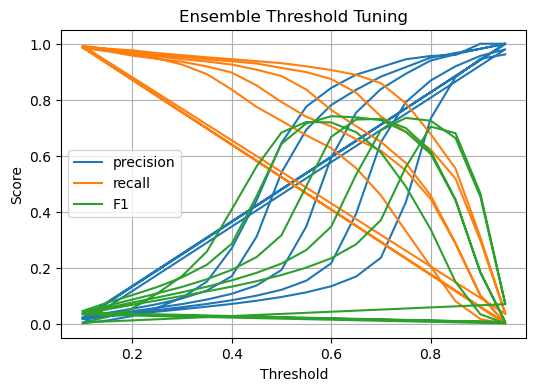

In [29]:
plt.figure(figsize=(6,4))
plt.plot(df_results["threshold"], df_results["precision"], label="precision")
plt.plot(df_results["threshold"], df_results["recall"], label="recall")
plt.plot(df_results["threshold"], df_results["F1"], label="F1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Ensemble Threshold Tuning")
plt.legend()
plt.grid()
plt.show()

### 각모델의 변수 중요도 top20

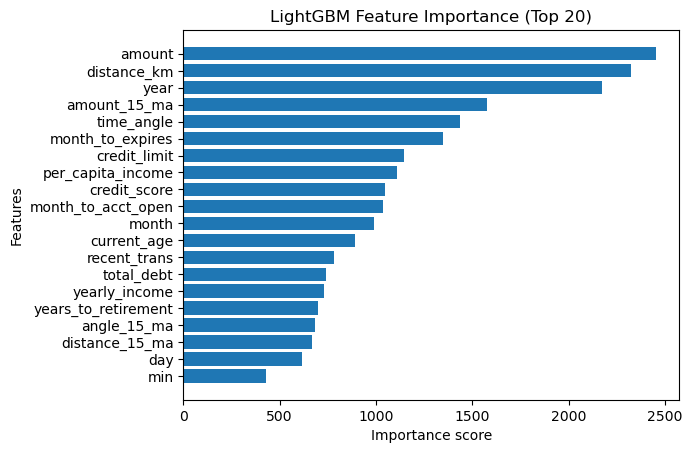

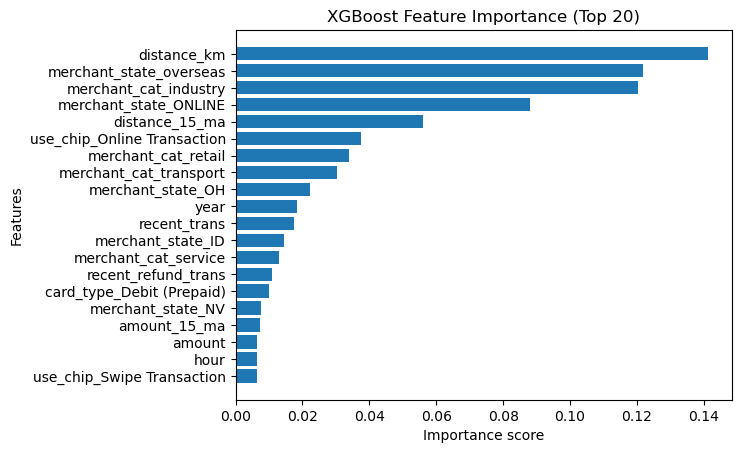

In [30]:
def plot_feature_importance(model_name, features, importances, top_n=20):
    idx = np.argsort(importances)[::-1][:top_n]
    plt.barh(np.array(features)[idx][::-1], np.array(importances)[idx][::-1])
    plt.title(f"{model_name} Feature Importance (Top {top_n})")
    plt.xlabel("Importance score")
    plt.ylabel("Features")
    plt.show()


# LightGBM
fi_lgb = lgb_model.feature_importances_
plot_feature_importance("LightGBM", X_val.columns, fi_lgb)

# XGBoost
fi_xgb = xgb_model.feature_importances_  # numpy array
plot_feature_importance("XGBoost", X_val.columns, fi_xgb)

# CatBoost
# fi_cat = cat_model.get_feature_importance()
# plot_feature_importance("CatBoost", X_val.columns, fi_cat)


### 각모델의 Permutation importance top 20

In [31]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    lgb_model, X_val, y_val,
    scoring="f1",
    n_repeats=1,
    random_state=42,
    n_jobs=16
)

import pandas as pd

fi = pd.DataFrame({
    "feature": X_val.columns,
    "importance": result.importances_mean
}).sort_values(by="importance", ascending=False)

print(fi.head(10))

                     feature  importance
20               distance_km    0.112000
102    merchant_cat_industry    0.071176
11                      year    0.052926
0                     amount    0.048448
106   merchant_cat_transport    0.024342
79   merchant_state_overseas    0.020891
25              amount_15_ma    0.020138
23              recent_trans    0.014942
105     merchant_cat_service    0.013908
103     merchant_cat_medical    0.010359


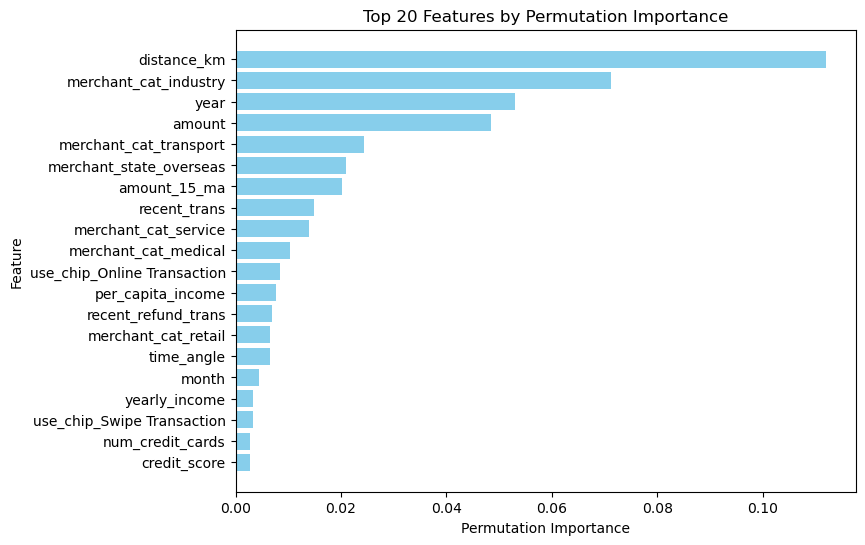

In [32]:
import matplotlib.pyplot as plt

top_features = fi.head(20)

plt.figure(figsize=(8, 6))
plt.barh(top_features["feature"], top_features["importance"], color="skyblue")
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 20 Features by Permutation Importance")
plt.gca().invert_yaxis() 
plt.show()

                         feature  importance
102        merchant_cat_industry    0.621300
20                   distance_km    0.547567
104          merchant_cat_retail    0.387511
21                distance_15_ma    0.371398
11                          year    0.344053
0                         amount    0.317578
105         merchant_cat_service    0.278410
106       merchant_cat_transport    0.236942
79       merchant_state_overseas    0.156912
26   use_chip_Online Transaction    0.118684


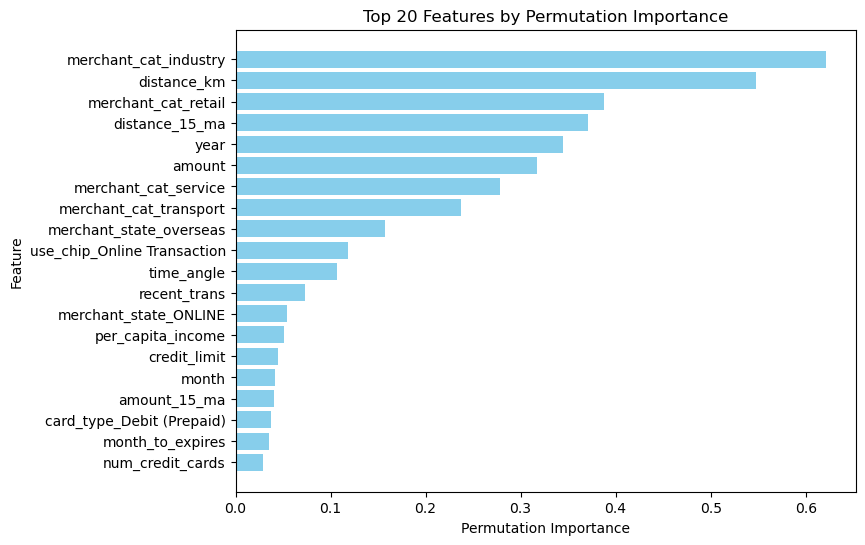

In [35]:
result_xgb = permutation_importance(
    xgb_model, X_val, y_val,
    scoring="f1",
    n_repeats=1,
    random_state=42,
    n_jobs=16
)

fi_xgb = pd.DataFrame({
    "feature": X_val.columns,
    "importance": result_xgb.importances_mean
}).sort_values(by="importance", ascending=False)

print(fi_xgb.head(10))

top_features_xgb = fi_xgb.head(20)

plt.figure(figsize=(8, 6))
plt.barh(top_features_xgb["feature"], top_features_xgb["importance"], color="skyblue")
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 20 Features by Permutation Importance")
plt.gca().invert_yaxis() 
plt.show()

### 로지스틱 회귀 메타 스태킹앙상블

In [ ]:
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")

float64로돌리니 메모리 부족으로 타입변환

In [37]:
#피쳐 이름에 특수 문자가 포함되어 오류 발생

#열 이름에 특수 문자 제거
X_train.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in X_train.columns]
X_val.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in X_val.columns]

#모델 재 학습(lgbm만)
lgb_model2 = lgb.LGBMClassifier(device='gpu',
    class_weight="balanced",                            
    n_estimators=1000,
    learning_rate=0.05,
    scale_pos_weight = 1, #가중치추가
    num_leaves = 63,
    max_depth = 5,
    min_child_samples = 100,                            
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

lgb_model2.fit(
    X_train.to_numpy(), y_train.to_numpy(),
    eval_set=[(X_val.to_numpy(), y_val.to_numpy())],
    categorical_feature=None
)
res_lgb2 = evaluate_model(lgb_model2, X_val, y_val, "LightGBM")


#xgb_model = xgb_model2 #xgb튜닝된 모델로 교체
#proba_xgb = xgb_model.predict_proba(X_val)[:, 1]


 LightGBM 결과
ROC-AUC: 0.9955
F1: 0.1346
PR-AUC: 0.5840
Precision: 0.0725
Recall: 0.9445
MCC: 0.2590
LogLoss: 0.0521
Confusion Matrix:
[[1748105   32222]
 [    148    2518]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1780327
           1       0.07      0.94      0.13      2666

    accuracy                           0.98   1782993
   macro avg       0.54      0.96      0.56   1782993
weighted avg       1.00      0.98      0.99   1782993



In [ ]:
stack_model = StackingClassifier(
    estimators=[
        ('log', log_model),
        ('rf', rf_model),
        ('lgb',lgb_model2),
        ('xgb', xgb_model),
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=3,                
    n_jobs=16,
    passthrough=False 
)

stack_model.fit(X_train, y_train)
res_stack = evaluate_model_cv(stack_model, X_val, y_val, cv)


In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def evaluate_model_cv(model, X, y, cv):
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1)
    pr_scores = cross_val_score(model, X, y, cv=cv, scoring="average_precision", n_jobs=-1)
    return f1_scores, pr_scores

res_stack = evaluate_model_cv(stack_model, X_val, y_val, cv)   

In [ ]:
res_stack = f1_scores, pr_scores 
print("\n===== Stacking Ensemble =====")
print("F1 평균:", np.mean(f1_scores).round(4))
print("PR-AUC 평균:", np.mean(pr_scores).round(4))

앙상블 임포턴스
퍼뮤테이션임포턴스

In [ ]:
'''
# 메타 입력 데이터 구성
stack_input = np.column_stack([proba_log,proba_rf,proba_lgb,proba_xgb]).astype("float32")

meta_model = LogisticRegression()
meta_model.fit(stack_input, y_val)
'''